## RUL prediction using 1D CNN

In this notebook, we will use 1D CNN to predict RUL of NASA's turbofan engine dataset FD002. We will show the implementation without going into the theory of CNN.

In [2]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/Cmaps.zip' -d /content/dataset


Archive:  /content/drive/MyDrive/Cmaps.zip
  inflating: /content/dataset/CMaps/Damage Propagation Modeling.pdf  
  inflating: /content/dataset/CMaps/RUL_FD001.txt  
  inflating: /content/dataset/CMaps/RUL_FD002.txt  
  inflating: /content/dataset/CMaps/RUL_FD003.txt  
  inflating: /content/dataset/CMaps/RUL_FD004.txt  
  inflating: /content/dataset/CMaps/readme.txt  
  inflating: /content/dataset/CMaps/test_FD001.txt  
  inflating: /content/dataset/CMaps/test_FD002.txt  
  inflating: /content/dataset/CMaps/test_FD003.txt  
  inflating: /content/dataset/CMaps/test_FD004.txt  
  inflating: /content/dataset/CMaps/train_FD001.txt  
  inflating: /content/dataset/CMaps/train_FD002.txt  
  inflating: /content/dataset/CMaps/train_FD003.txt  
  inflating: /content/dataset/CMaps/train_FD004.txt  
  inflating: /content/dataset/CMaps/x.txt  


In [4]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 2


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [5]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.12.0
Numpy version:  1.22.4
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 150
* Window length: 20
* Shift: 1
* Data scaling: MinMaxScaling with feature range of [-1, 1]. We will **not** preform individual enginewise scaling. Rather, we will apply the scaling to the full column of training data. Why do we do that? One reason is to achieve to better result. If enginewise scaling is preformed, we achieve higher RMSE value. But if we perform, full dataset scaling, we achieve lower RMSE values (which is better).

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

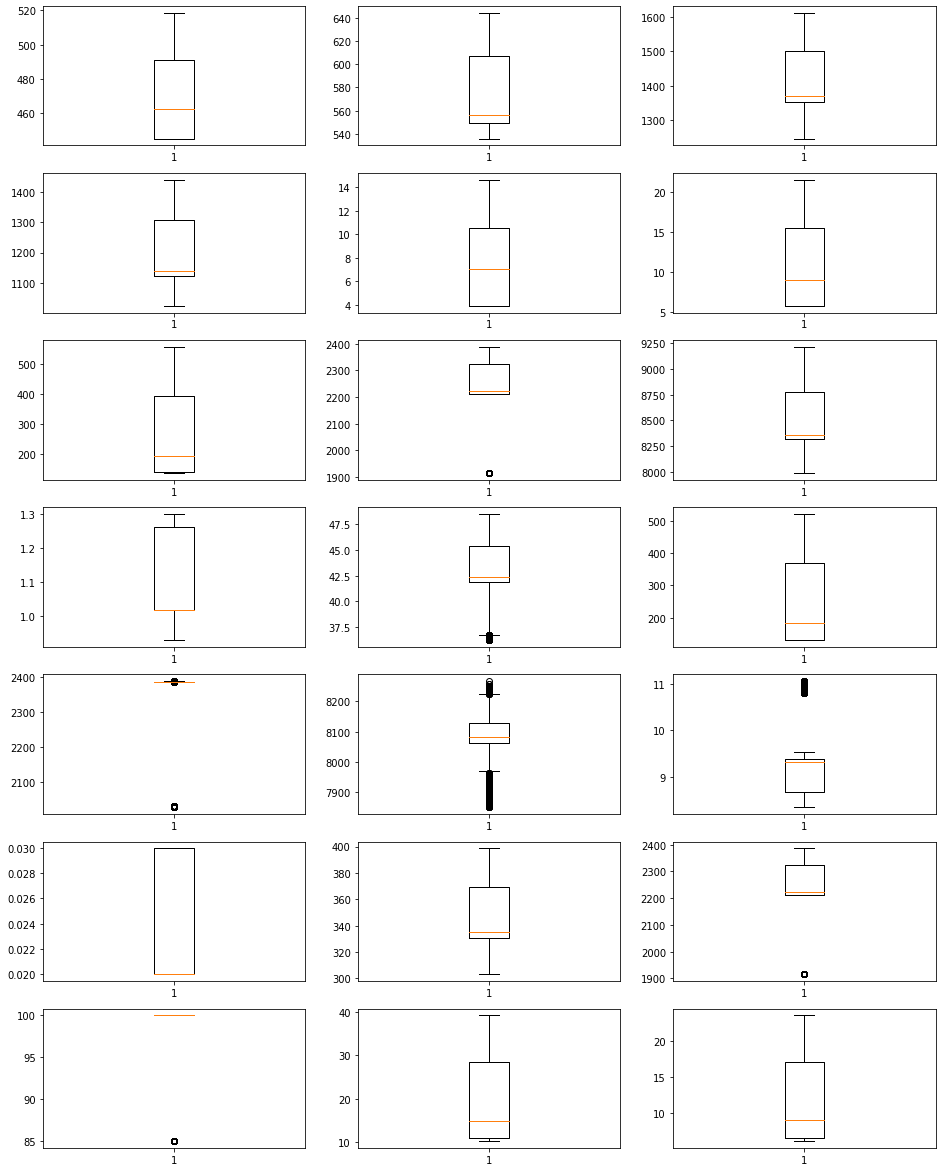

In [ ]:
train_data = pd.read_csv("/home/biswajit/data/cmapss_data/train_FD002.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [6]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [7]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [8]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In the following cell, we will apply `MinMaxScaling` to the full trianing dataset.

In [9]:

window_length = 20
shift = 1
early_rul = 150
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-7-1715ad1c7bf6>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-7-1715ad1c7bf6>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inf

Processed trianing data shape:  (48819, 20, 21)
Processed training ruls shape:  (48819,)
Processed test data shape:  (1289, 20, 21)
True RUL shape:  (259,)


<ipython-input-7-1715ad1c7bf6>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-8-dc420933ba69>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inf

Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [10]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

## Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [11]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (39055, 20, 21)
Processed validation data shape:  (9764, 20, 21)
Processed train targets shape:  (39055,)
Processed validation targets shape:  (9764,)


## 1D CNN model

In [24]:
def create_compiled_model():
    model = Sequential([
        layers.Conv1D(128, 5, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 5, activation = "relu"),
        layers.Conv1D(32, 5, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", metrics=["mae"], optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [25]:
def scheduler(epoch):
    if epoch < 15:
        return 0.001
    else:
        return 0.0001

In [26]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [27]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 25,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
611/611 - 12s - loss: 0.0487 - mae: 0.1754 - val_loss: 0.0333 - val_mae: 0.1434 - lr: 0.0010 - 12s/epoch - 19ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/25
611/611 - 10s - loss: 0.0326 - mae: 0.1423 - val_loss: 0.0359 - val_mae: 0.1518 - lr: 0.0010 - 10s/epoch - 17ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/25
611/611 - 8s - loss: 0.0300 - mae: 0.1359 - val_loss: 0.0278 - val_mae: 0.1305 - lr: 0.0010 - 8s/epoch - 13ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/25
611/611 - 10s - loss: 0.0244 - mae: 0.1214 - val_loss: 0.0382 - val_mae: 0.1512 - lr: 0.0010 - 10s/epoch - 17ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/25
611/611 - 10s - loss: 0.0187 - mae: 0.1052 - val_loss: 0.0210 - val_mae: 0.1128 - lr: 0.0010 - 10s/epoch - 17ms/step

Epoch 6: LearningRateScheduler setting le

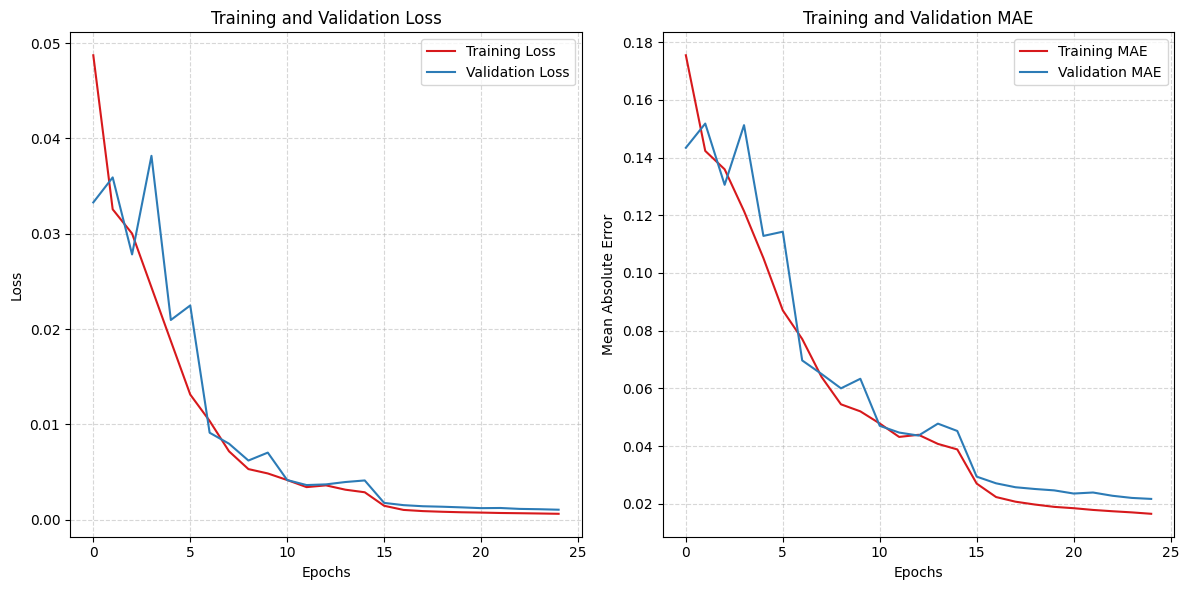

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    This function takes a history object from the training of a model
    and plots the training and validation loss and Mean Absolute Error (MAE).

    :param history: history object from model training
    """

    # Plotting the Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color='#D7191C', label='Training Loss')
    plt.plot(history.history['val_loss'], color='#2C7BB6', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plotting the Mean Absolute Error (MAE)
    plt.subplot(1, 2, 2)

    # Check if 'mae' or 'mean_absolute_error' is used as key
    mae_key = 'mae' if 'mae' in history.history else 'mean_absolute_error'
    val_mae_key = 'val_mae' if 'val_mae' in history.history else 'val_mean_absolute_error'

    plt.plot(history.history[mae_key], color='#D7191C', label='Training MAE')
    plt.plot(history.history[val_mae_key], color='#2C7BB6', label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history(history)


### Prediction

In [16]:
rul_pred_scaled = model.predict(processed_test_data).reshape(-1)
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

41/41 [==============================] - 0s 3ms/step
RMSE:  30.387388685715596


### Save the model

In [17]:
tf.keras.models.save_model(model, "FD002_1D_CNN_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

We will now compute the RMSE by taking only last example of each engine.

In [18]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  30.00014194818194


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [19]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [20]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  16933.690115533696


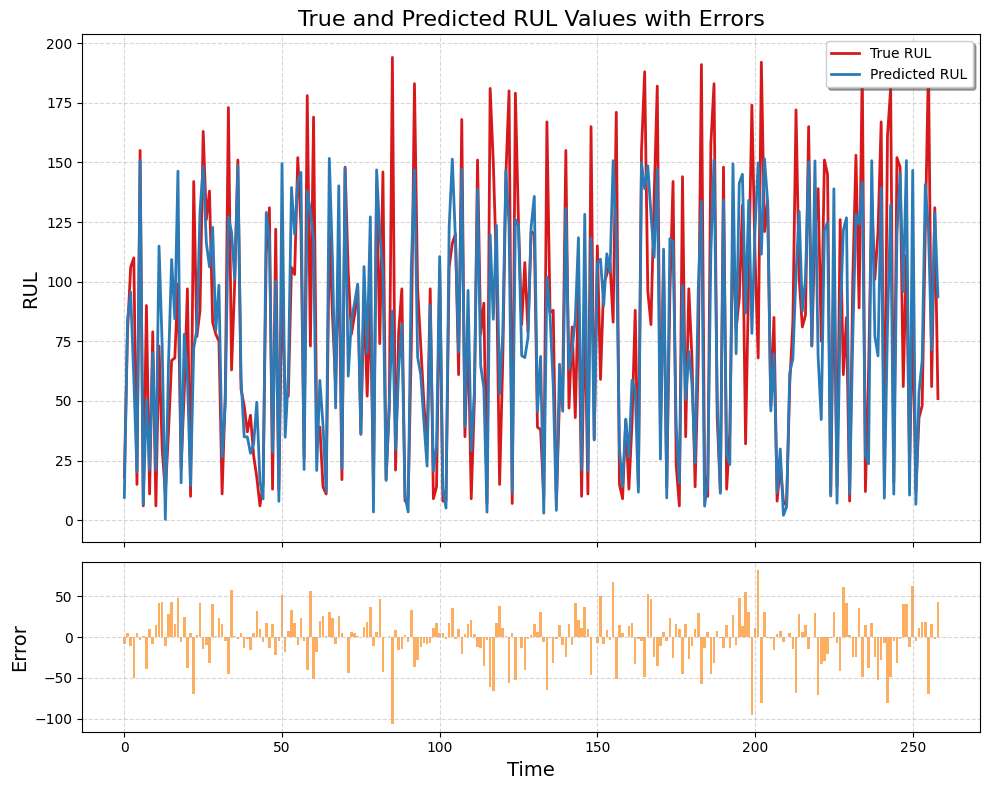

In [23]:

# Calculate the errors
errors = [pred - true for pred, true in zip(preds_for_last_example, true_rul)]

# Create a new figure object with subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# ----- Main Plot: True and Predicted RUL Values -----
# Plot true and predicted RUL values
ax1.plot(true_rul, label="True RUL", color="#D7191C", linewidth=2)
ax1.plot(preds_for_last_example, label="Predicted RUL", color="#2C7BB6", linewidth=2)

# Add a grid
ax1.grid(True, linestyle='--', alpha=0.5)

# Set labels for y axis
ax1.set_ylabel("RUL", fontsize=14)

# Set a title for the plot
ax1.set_title("True and Predicted RUL Values with Errors", fontsize=16)

# Add a legend with fancy box
legend = ax1.legend(loc='upper right', shadow=True, fontsize='medium')

# ----- Secondary Plot: Error Values -----
# Plot the errors
ax2.bar(range(len(errors)), errors, color="#FDAE61")

# Add a grid
ax2.grid(True, linestyle='--', alpha=0.5)

# Set labels for x and y axis
ax2.set_xlabel("Time", fontsize=14)
ax2.set_ylabel("Error", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

# Attention mechanism

In [49]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, MultiHeadAttention, Dropout, Add

def create_compiled_model_with_attention_and_residual(input_shape, num_heads=8, dropout_rate=0.5):
    # Input Layer
    inputs = Input(shape=input_shape)

    # Initial Conv1D layers
    x = Conv1D(128, 5, activation="relu")(inputs)


    # Multi-Head Attention
    query = x
    key = x
    value = x
    x = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[1])(query, key, value)

    # Dropout
    x = Dropout(rate=dropout_rate)(x)

    # Residual connection (Add the output from multi-head attention to its input)
    x = Add()([x, query])

    # Remaining layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(1)(x)

    # Build model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(loss="mse", metrics=["mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model

# Example usage
input_shape = (window_length, processed_train_data.shape[2])
model_with_attention_and_residual = create_compiled_model_with_attention_and_residual(input_shape)


In [68]:

history =model_with_attention_and_residual.fit(processed_train_data, processed_train_targets, epochs = 50,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
611/611 - 23s - loss: 0.0121 - mae: 0.0801 - val_loss: 0.0077 - val_mae: 0.0645 - lr: 0.0010 - 23s/epoch - 37ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
611/611 - 21s - loss: 0.0056 - mae: 0.0554 - val_loss: 0.0071 - val_mae: 0.0610 - lr: 0.0010 - 21s/epoch - 34ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
611/611 - 22s - loss: 0.0049 - mae: 0.0522 - val_loss: 0.0064 - val_mae: 0.0582 - lr: 0.0010 - 22s/epoch - 35ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/50
611/611 - 20s - loss: 0.0054 - mae: 0.0547 - val_loss: 0.0064 - val_mae: 0.0576 - lr: 0.0010 - 20s/epoch - 32ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/50
611/611 - 21s - loss: 0.0048 - mae: 0.0517 - val_loss: 0.0078 - val_mae: 0.0652 - lr: 0.0010 - 21s/epoch - 35ms/step

Epoch 6: LearningRateScheduler setting 

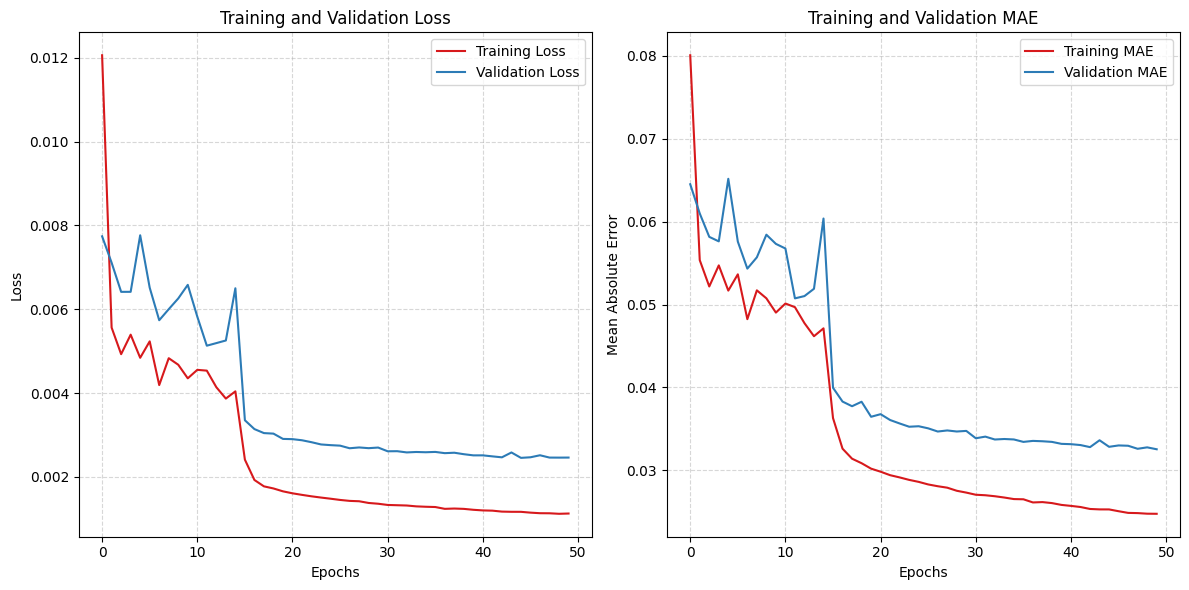

In [69]:

# Example usage:
plot_training_history(history)

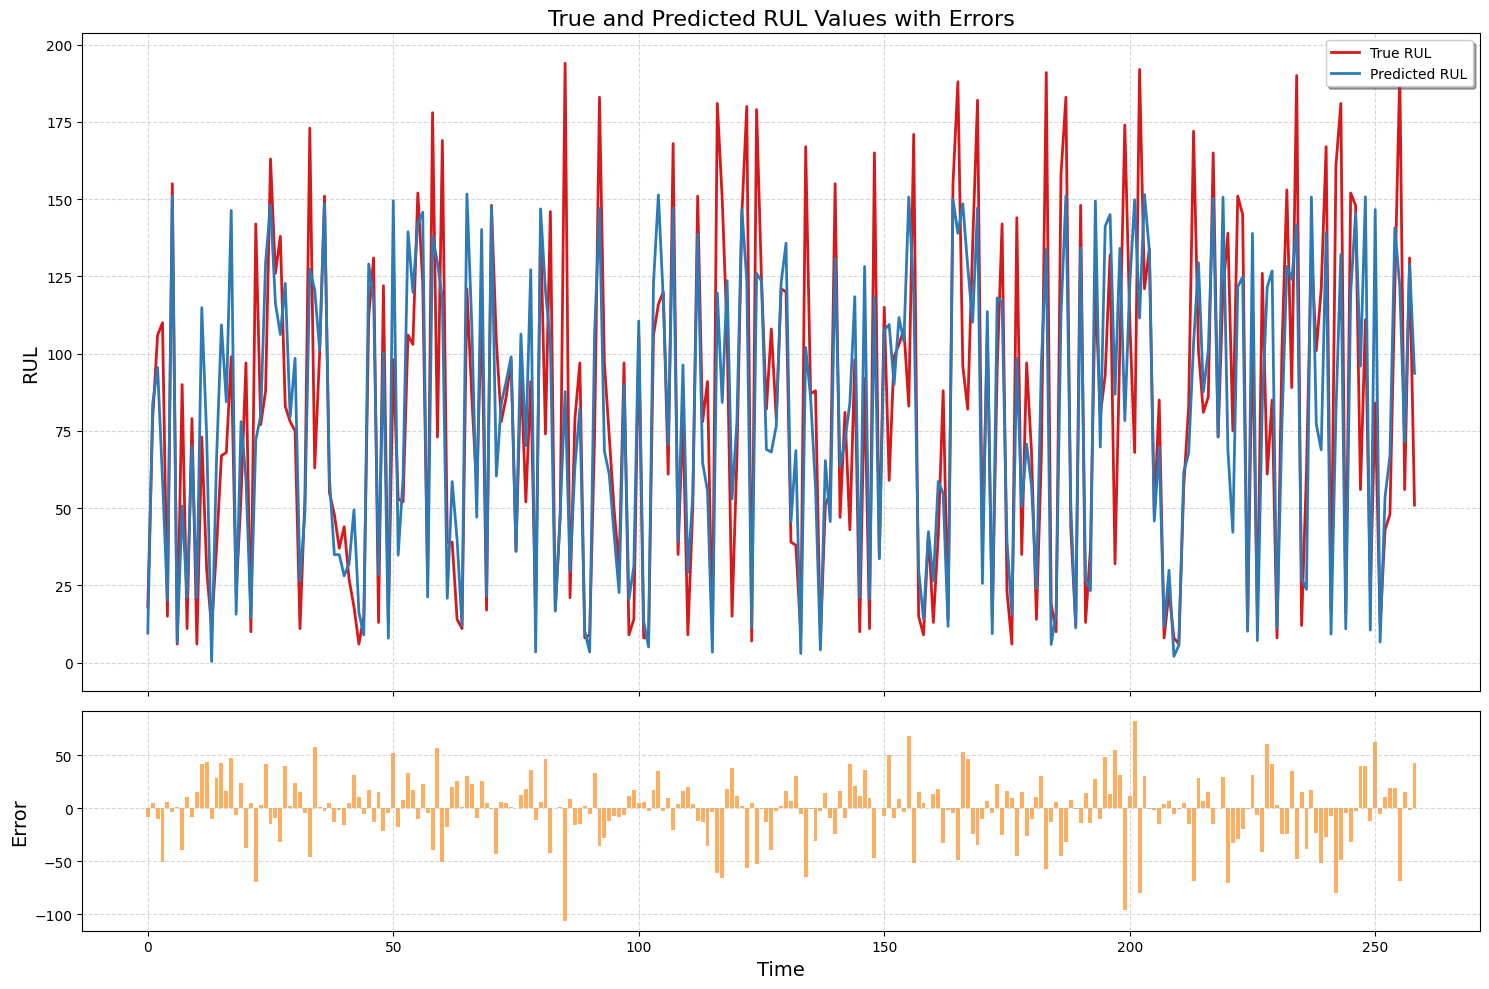

In [70]:

# Calculate the errors
errors = [pred - true for pred, true in zip(preds_for_last_example, true_rul)]

# Create a new figure object with subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# ----- Main Plot: True and Predicted RUL Values -----
# Plot true and predicted RUL values
ax1.plot(true_rul, label="True RUL", color="#D7191C", linewidth=2)
ax1.plot(preds_for_last_example, label="Predicted RUL", color="#2C7BB6", linewidth=2)

# Add a grid
ax1.grid(True, linestyle='--', alpha=0.5)

# Set labels for y axis
ax1.set_ylabel("RUL", fontsize=14)

# Set a title for the plot
ax1.set_title("True and Predicted RUL Values with Errors", fontsize=16)

# Add a legend with fancy box
legend = ax1.legend(loc='upper right', shadow=True, fontsize='medium')

# ----- Secondary Plot: Error Values -----
# Plot the errors
ax2.bar(range(len(errors)), errors, color="#FDAE61")

# Add a grid
ax2.grid(True, linestyle='--', alpha=0.5)

# Set labels for x and y axis
ax2.set_xlabel("Time", fontsize=14)
ax2.set_ylabel("Error", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [71]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import MultiHeadAttention

def create_hybrid_model(input_shape, num_heads, num_classes):
    # Input Layer
    inputs = Input(shape=input_shape)

    # 1D CNN Layers
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # LSTM Layer
    x = layers.LSTM(128, return_sequences=True)(x)

    # MultiHead Attention Layer
    query = layers.Dense(32)(x)
    key = layers.Dense(32)(x)
    value = layers.Dense(32)(x)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=32)(query, key, value)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Additional Layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(1, activation='linear')(x)

    # Build Model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Example usage
input_shape = (None, 21)  # Specify the input shape, (None, feature_size)
num_heads = 8  # Number of attention heads
num_classes = 10  # Number of output classes or labels
hybrid_model = create_hybrid_model(input_shape, num_heads, num_classes)
hybrid_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
hybrid_model.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, None, 21)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, None, 64)     4096        ['input_14[0][0]']               
                                                                                                  
 max_pooling1d_5 (MaxPooling1D)  (None, None, 64)    0           ['conv1d_21[0][0]']              
                                                                                                  
 lstm_5 (LSTM)                  (None, None, 128)    98816       ['max_pooling1d_5[0][0]']        
                                                                                            

In [72]:

history = hybrid_model.fit(processed_train_data, processed_train_targets, epochs = 50,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
611/611 - 33s - loss: 0.0695 - mae: 0.2070 - val_loss: 0.0342 - val_mae: 0.1501 - lr: 0.0010 - 33s/epoch - 55ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
611/611 - 29s - loss: 0.0438 - mae: 0.1655 - val_loss: 0.0320 - val_mae: 0.1474 - lr: 0.0010 - 29s/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
611/611 - 29s - loss: 0.0383 - mae: 0.1557 - val_loss: 0.0328 - val_mae: 0.1505 - lr: 0.0010 - 29s/epoch - 47ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/50
611/611 - 28s - loss: 0.0357 - mae: 0.1512 - val_loss: 0.0295 - val_mae: 0.1379 - lr: 0.0010 - 28s/epoch - 46ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/50
611/611 - 28s - loss: 0.0337 - mae: 0.1476 - val_loss: 0.0300 - val_mae: 0.1415 - lr: 0.0010 - 28s/epoch - 46ms/step

Epoch 6: LearningRateScheduler setting 

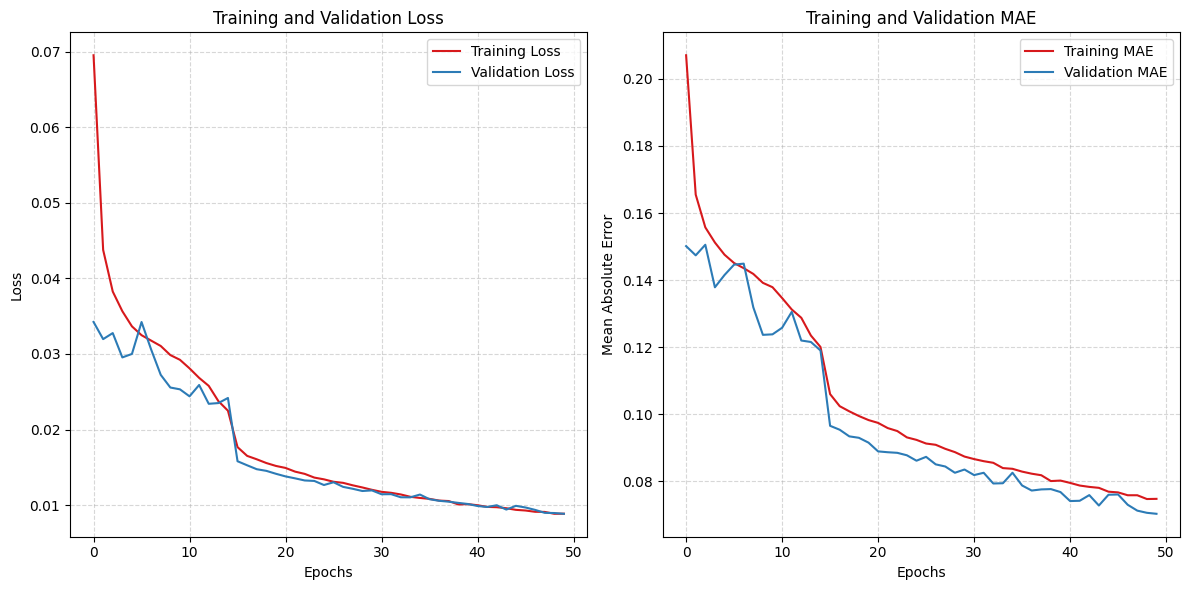

In [73]:
# Example usage:
plot_training_history(history)

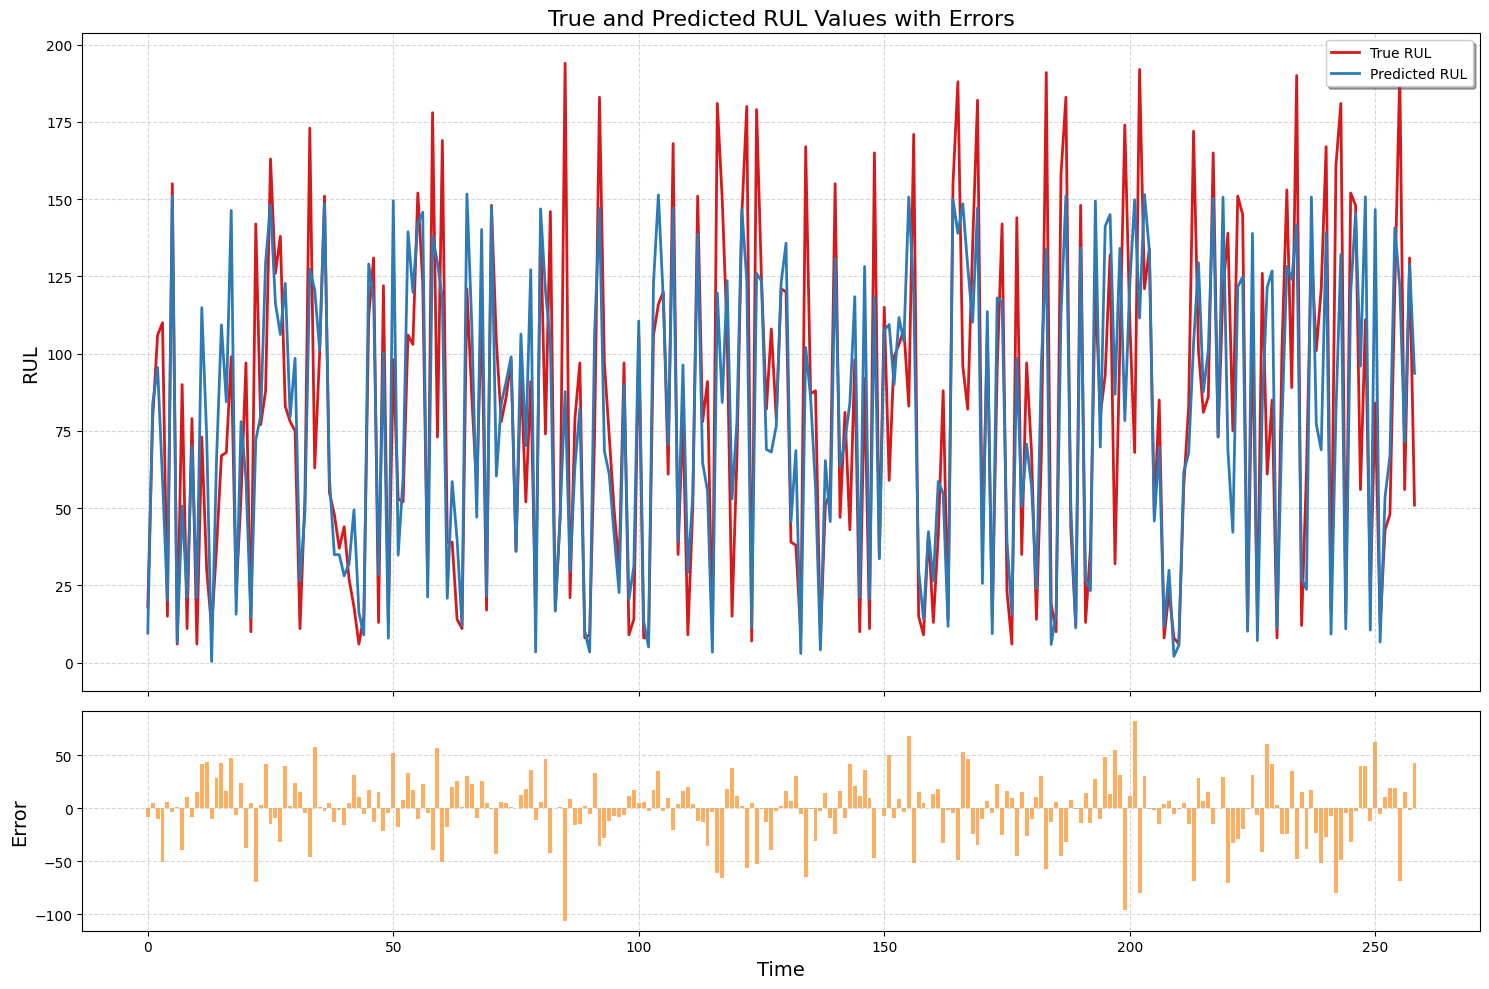

In [74]:

# Calculate the errors
errors = [pred - true for pred, true in zip(preds_for_last_example, true_rul)]

# Create a new figure object with subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# ----- Main Plot: True and Predicted RUL Values -----
# Plot true and predicted RUL values
ax1.plot(true_rul, label="True RUL", color="#D7191C", linewidth=2)
ax1.plot(preds_for_last_example, label="Predicted RUL", color="#2C7BB6", linewidth=2)

# Add a grid
ax1.grid(True, linestyle='--', alpha=0.5)

# Set labels for y axis
ax1.set_ylabel("RUL", fontsize=14)

# Set a title for the plot
ax1.set_title("True and Predicted RUL Values with Errors", fontsize=16)

# Add a legend with fancy box
legend = ax1.legend(loc='upper right', shadow=True, fontsize='medium')

# ----- Secondary Plot: Error Values -----
# Plot the errors
ax2.bar(range(len(errors)), errors, color="#FDAE61")

# Add a grid
ax2.grid(True, linestyle='--', alpha=0.5)

# Set labels for x and y axis
ax2.set_xlabel("Time", fontsize=14)
ax2.set_ylabel("Error", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

# LSTM

In [ ]:
## Create a custom model
class CreateModel(tf.keras.Model):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.lstm_layer_1 = layers.LSTM(128, input_shape = input_shape, return_sequences = True, activation = "tanh")
        self.lstm_layer_2 = layers.LSTM(64, activation = "tanh", return_sequences= True)
        self.lstm_layer_3 = layers.LSTM(32, activation = "tanh")
        self.dense_1 = layers.Dense(64, activation = "relu")
        self.dense_2 = layers.Dense(96, activation = "relu")
        self.dense_3 = layers.Dense(1)


    def call(self, input_data, mask = None, **kwargs):
        x = self.lstm_layer_1(input_data, mask = mask)
        x = self.lstm_layer_2(x)
        x = self.lstm_layer_3(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x)